In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
import sys
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import lab2rgb, rgb2lab
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from cGAN_CL.compute_metrics import compute_metrics
from cGAN.models import MainModel, build_res_unet 
from COLORIZATION.colorizers import *
from tqdm import tqdm

In [30]:
def model2_outputs(data_path, model, device): 
    #Image transformation
    SIZE = 256
    class ColorizationDataset(Dataset):
        def __init__(self, paths):
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE), Image.BICUBIC),
                transforms.ToTensor()
            ])
            self.paths = paths
        
        def __getitem__(self, idx):
            try:
                img = Image.open(self.paths[idx]).convert("RGB")
                img = self.transforms(img)
                img_np = np.array(img.permute(1, 2, 0))  # Convert to HWC format for rgb2lab
                img_lab = rgb2lab(img_np).astype("float32")
                img_lab = torch.tensor(img_lab).permute(2, 0, 1)  # Convert to CHW format
                L = img_lab[[0], ...] / 50. - 1.  # Normalize L
                ab = img_lab[[1, 2], ...] / 110.  # Normalize ab
                return {'L': L, 'ab': ab, 'path': self.paths[idx]}
            except Exception as e:
                print(f"Error loading image {self.paths[idx]}: {e}")
                return None  # Skip the image
        
        def __len__(self):
            return len(self.paths)

    def make_dataloader(data_path, batch_size=16, num_workers=2, pin_memory=True):
        dataset = ColorizationDataset(data_path)
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle = False, pin_memory=pin_memory)
        return dataloader

    def colorize_model2(data, model, device):
        colorized_results = []
        for batch in tqdm(data, desc="Model: Colorizing images"):
            if batch is None:
                continue  # Skip corrupted images
            
            L, ab, paths = batch['L'].to(device), batch['ab'].to(device), batch['path']
            
            with torch.no_grad():
                pred_ab = model.net_G(L)  # Output should be ab channels
            
            for i in range(len(paths)):
                L_img = (L[i].cpu().numpy() + 1.) * 50.  # De-normalize L
                pred_ab_img = pred_ab[i].cpu().numpy() * 110.  # De-normalize ab
                lab_img = np.concatenate((L_img, pred_ab_img), axis=0).transpose(1, 2, 0)
                colorized_rgb = (lab2rgb(lab_img) * 255).astype("uint8")
                colorized_rgb = torch.from_numpy(colorized_rgb).permute(2, 0, 1)  # Convert to CHW format
                colorized_results.append(colorized_rgb)
        return colorized_results

    data = make_dataloader(data_path)
    return colorize_model2(data, model, device)



In [31]:
def model1_outputs(data_path, colorizer, device):
    colorised_results = []
    for img_path in tqdm(data_path):
        try:
            img = load_img(img_path)
            (tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256, 256))

            tens_l_rs = tens_l_rs.cuda()
            out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer(tens_l_rs).cpu())
            result = (np.clip(out_img_siggraph17, 0, 1) * 255).astype(np.uint8)
            result = torch.from_numpy(result)  # Convert NumPy array to PyTorch tensor
            result = result.permute(2, 0, 1)  # Example: for changing HWC → CHW
            colorised_results.append(result)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return colorised_results

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = siggraph17(pretrained=True).eval()
model1.cuda()


net_G = build_res_unet(n_input=1, n_output=2, size=256)
model2 = MainModel(net_G=net_G)
model2.load_state_dict(torch.load("/u/student/2021/cs21btech11002/CV_Project/cGAN/cGAN-unet.pt", map_location=device))  # Load trained MainModel
model2.to(device)
model2.eval()
print("Model 1 and Model 2 loaded successfully.")

/u/student/2021/cs21btech11002/miniconda3/envs/cGAN/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/student/2021/cs21btech11002/miniconda3/envs/cGAN/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model initialized with norm initialization
Model 1 and Model 2 loaded successfully.


In [33]:
def ensemble_weighted_mse_loss(model1_output, model2_output, selector_probs, target):
    mse1 = ((model1_output.float() - target.float()) ** 2).mean(dim=[1,2,3])  # [B]
    mse2 = ((model2_output.float() - target.float()) ** 2).mean(dim=[1,2,3])  # [B]
    weighted_loss = selector_probs[:, 0] * mse1 + selector_probs[:, 1] * mse2  # [B]
    return weighted_loss.mean()


In [ ]:
# === Configuration ===
BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DATA_DIR = "../unlabeled2017" # folder containing 'train' and 'val' subfolders

paths_coco = glob(os.path.join(DATA_DIR, '../unlabeled2017', '*'))
paths_image_net = glob(os.path.join(DATA_DIR, '../ImageNet', '**', '*.JPEG'), recursive=True)
train_paths = paths_coco[:800] + paths_image_net[:800]

model1_train_outputs = model1_outputs(train_paths, model1, device)
model2_train_outputs = model2_outputs(train_paths, model2, device)

Train paths: 1600, Test paths: 19959


  1%|          | 12/1600 [00:03<06:50,  3.87it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
  2%|▏         | 24/1600 [00:06<06:16,  4.18it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
  2%|▏         | 26/1600 [00:06<07:22,  3.55it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].trans

In [38]:
# === Transforms for Grayscale + Inception ===
transform = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC)
])
transform_input = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor()
])



class EnsembleTrainingDataset(Dataset):
    def __init__(self, image_paths, m1_outputs, m2_outputs, transform=None, transform_input=None):
        self.image_paths = image_paths
        self.m1_outputs = m1_outputs
        self.m2_outputs = m2_outputs
        self.transform = transform
        self.transform_input = transform_input

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image_rgb = Image.open(path).convert("RGB")
        input = self.transform_input(image_rgb) if self.transform_input else image_rgb
        image_rgb = torch.tensor(np.array(image_rgb)).permute(2, 0, 1)
        target = self.transform(image_rgb) if self.transform else image_rgb
        out1 = self.m1_outputs[idx]
        out2 = self.m2_outputs[idx]
        out1 = self.transform(out1) if self.transform else out1
        out2 = self.transform(out2) if self.transform else out2

        return input, out1, out2, target

train_dataset = EnsembleTrainingDataset(train_paths, model1_train_outputs, model2_train_outputs, transform=transform, transform_input=transform_input)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [39]:
import clip
from torchvision import transforms
import torch.nn as nn

# === Load CLIP ===
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()

# Freeze CLIP
for param in clip_model.parameters():
    param.requires_grad = False

# Replace CLIP image encoder's projection with a custom selector head
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

selector_head = nn.Sequential(
    nn.Linear(clip_model.visual.output_dim, 512),
    nn.ReLU(),
    nn.Linear(512, NUM_CLASSES)
).to(device)

selector_head.apply(init_weights)

# Optimizer for selector head
optimizer = optim.Adam(selector_head.parameters(), lr=LEARNING_RATE)

# === Training Loop ===
NUM_EPOCHS = 25
losses = []
updates = 0
non_updates = 0

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}") 
    running_loss = 0.0
    for input_img, out1, out2, target in tqdm(train_loader):
        input_img = input_img.to(device)       # Grayscale: [B, 1, H, W]
        out1 = out1.to(device)
        out2 = out2.to(device)
        target = target.to(device)

        # Convert to 3 channels (RGB format for CLIP)
        input_rgb = input_img.repeat(1, 3, 1, 1)

        # Resize and normalize input for CLIP using preprocess (same as transforms for CLIP)
        input_rgb = nn.functional.interpolate(input_rgb, size=224, mode='bicubic', align_corners=False)
        input_rgb = input_rgb.clamp(0, 1)  # Ensure range is [0, 1]

        # Normalize manually using CLIP mean/std
        normalize = transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
        input_rgb = normalize(input_rgb)

        # Get CLIP visual embeddings
        with torch.no_grad():
            features = clip_model.encode_image(input_rgb)  # [B, D]
            features = features.float()
        
        # Predict selector probabilities
        selector_logits = selector_head(features)  # [B, NUM_CLASSES]
        selector_probs = torch.softmax(selector_logits, dim=1)  # [B, NUM_CLASSES]

        # Compute weighted MSE loss
        loss = ensemble_weighted_mse_loss(out1, out2, selector_probs, target)
        # Check if weights are updated
        before_update = selector_head[2].weight.clone()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        after_update = selector_head[2].weight.clone()
        if torch.equal(before_update, after_update):
            non_updates += 1
        else:
            updates += 1
        running_loss += loss

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Training Loss: {epoch_loss}")


  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25


  4%|▍         | 1/25 [00:22<08:57, 22.40s/it]

Training Loss: 269.6669006347656

Epoch 2/25


  8%|▊         | 2/25 [00:38<07:05, 18.52s/it]

Training Loss: 255.57003784179688

Epoch 3/25


 12%|█▏        | 3/25 [00:54<06:27, 17.63s/it]

Training Loss: 225.3173370361328

Epoch 4/25


 16%|█▌        | 4/25 [01:11<06:05, 17.39s/it]

Training Loss: 218.83319091796875

Epoch 5/25


 20%|██        | 5/25 [01:28<05:40, 17.02s/it]

Training Loss: 213.67446899414062

Epoch 6/25


 24%|██▍       | 6/25 [01:45<05:22, 16.96s/it]

Training Loss: 212.14181518554688

Epoch 7/25


 28%|██▊       | 7/25 [04:13<17:59, 59.96s/it]

Training Loss: 211.1863250732422

Epoch 8/25


 32%|███▏      | 8/25 [04:49<14:47, 52.19s/it]

Training Loss: 210.49668884277344

Epoch 9/25


 36%|███▌      | 9/25 [05:05<10:58, 41.16s/it]

Training Loss: 209.9573211669922

Epoch 10/25


 40%|████      | 10/25 [05:23<08:27, 33.86s/it]

Training Loss: 209.5076446533203

Epoch 11/25


 44%|████▍     | 11/25 [05:40<06:43, 28.82s/it]

Training Loss: 209.11358642578125

Epoch 12/25


 48%|████▊     | 12/25 [05:57<05:26, 25.10s/it]

Training Loss: 208.75965881347656

Epoch 13/25


 52%|█████▏    | 13/25 [06:14<04:32, 22.68s/it]

Training Loss: 208.43527221679688

Epoch 14/25


 56%|█████▌    | 14/25 [06:31<03:51, 21.05s/it]

Training Loss: 208.1365509033203

Epoch 15/25


 60%|██████    | 15/25 [06:48<03:17, 19.76s/it]

Training Loss: 207.8604278564453

Epoch 16/25


 64%|██████▍   | 16/25 [07:05<02:49, 18.85s/it]

Training Loss: 207.6086883544922

Epoch 17/25


 68%|██████▊   | 17/25 [07:21<02:24, 18.10s/it]

Training Loss: 207.368896484375

Epoch 18/25


 72%|███████▏  | 18/25 [07:38<02:03, 17.71s/it]

Training Loss: 207.13534545898438

Epoch 19/25


 76%|███████▌  | 19/25 [07:55<01:44, 17.40s/it]

Training Loss: 206.89697265625

Epoch 20/25


 80%|████████  | 20/25 [08:12<01:26, 17.33s/it]

Training Loss: 206.64016723632812

Epoch 21/25


 84%|████████▍ | 21/25 [08:28<01:08, 17.11s/it]

Training Loss: 206.36529541015625

Epoch 22/25


 88%|████████▊ | 22/25 [08:45<00:50, 16.98s/it]

Training Loss: 206.0771484375

Epoch 23/25


 92%|█████████▏| 23/25 [09:02<00:33, 16.97s/it]

Training Loss: 205.7972412109375

Epoch 24/25


 96%|█████████▌| 24/25 [09:20<00:17, 17.14s/it]

Training Loss: 205.54884338378906

Epoch 25/25


100%|██████████| 25/25 [09:36<00:00, 23.05s/it]

Training Loss: 205.3300323486328


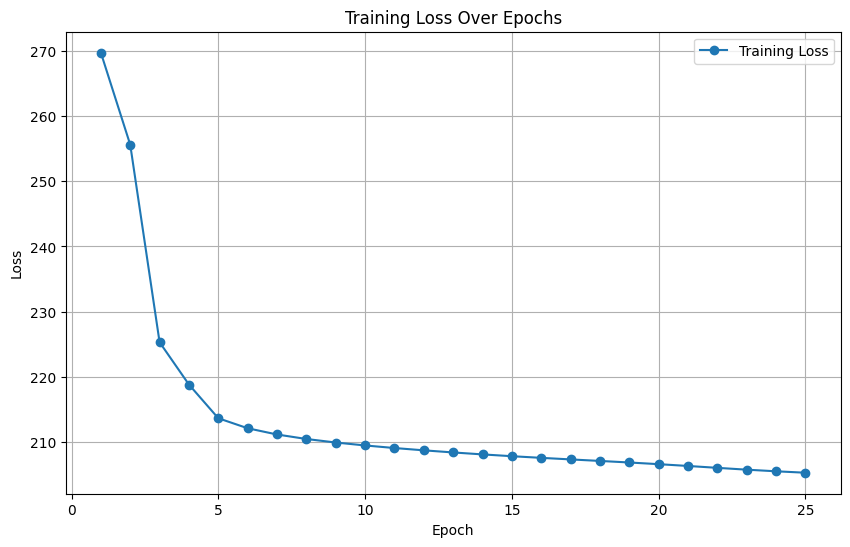

In [40]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), [loss.item() for loss in losses], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [58]:
def test_model(test_loader):
    choices = []
    best = []
    for input_img, out1, out2, target in tqdm(test_loader):
        input_img = input_img.to(device)
        out1 = out1.to(device)
        out2 = out2.to(device)
        target = target.to(device)
        # Convert to 3 channels (RGB format for CLIP)
        input_rgb = input_img.repeat(1, 3, 1, 1)
        # Resize and normalize input for CLIP using preprocess (same as transforms for CLIP)
        input_rgb = nn.functional.interpolate(input_rgb, size=224, mode='bicubic', align_corners=False)
        input_rgb = input_rgb.clamp(0, 1)  # Ensure range is [0, 1]
        # Normalize manually using CLIP mean/std
        normalize = transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
        input_rgb = normalize(input_rgb)

        with torch.no_grad():
            features = clip_model.encode_image(input_rgb)  # [B, D]
            features = features.float()
            # Predict selector probabilities
            selector_logits = selector_head(features)  # [B, NUM_CLASSES]
            selector_probs = torch.softmax(selector_logits, dim=1)  # [B, NUM_CLASSES]
            mse1 = ((out1.float() - target.float()) ** 2).mean(dim=[1,2,3])  # [B]
            mse2 = ((out2.float() - target.float()) ** 2).mean(dim=[1,2,3])  # [B]
            best.extend((mse2<=mse1).int())
            choices.extend(torch.argmax(selector_probs, dim=1))
            
    return choices, best

In [62]:
def inference(test_path):
    model1_test_outputs = model1_outputs(test_path, model1, device)
    model2_test_outputs = model2_outputs(test_path, model2, device)
    test_dataset = EnsembleTrainingDataset(test_path, model1_test_outputs, model2_test_outputs, transform=transform, transform_input=transform_input)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4, shuffle=False, num_workers=2)
    choices, best_choices = test_model(test_loader)
    # Find overlap between best_choices and choices
    index = [i for i, (best, choice) in enumerate(zip(best_choices, choices)) if best == choice]
    overlap = sum(1 for best, choice in zip(best_choices, choices) if best == choice)
    choices_tensor = torch.tensor(choices)
    num_ones = (choices_tensor == 1).sum().item()
    num_zeros = (choices_tensor == 0).sum().item()
    print(f"Number of 1's: {num_ones}")
    print(f"Number of 0's: {num_zeros}")
    print(f"Accuracy: {overlap/len(choices) * 100:.2f}%")
    return choices, model1_test_outputs, model2_test_outputs


In [60]:

paths_coco_test = sorted(glob(os.path.join(DATA_DIR, '../test_COCO', '*')))[:2000]
paths_image_net_test = sorted(glob(os.path.join(DATA_DIR, '../test_ImageNet', '*')))[:2000]

In [63]:
choices_coco, m1_coco, m2_coco = inference(paths_coco_test)
results_coco = [m1 if choice == 0 else m2 for choice, m1, m2 in zip(choices_coco, m1_coco, m2_coco)]


  0%|          | 0/2000 [00:00<?, ?it/s]

Model: Colorizing images:   1%|          | 1/125 [00:01<02:52,  1.39s/it]/tmp/ipykernel_2183398/1344644219.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  colorized_rgb = (lab2rgb(lab_img) * 255).astype("uint8")
Model: Colorizing images:   6%|▌         | 7/125 [00:02<00:36,  3.27it/s]/tmp/ipykernel_2183398/1344644219.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  colorized_rgb = (lab2rgb(lab_img) * 255).astype("uint8")
Model: Colorizing images:  26%|██▋       | 33/125 [00:09<00:21,  4.20it/s]/tmp/ipykernel_2183398/1344644219.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  colorized_rgb = (lab2rgb(lab_img) * 255).astype("uint8")
Model: Colorizing images:  46%|████▋     | 58/125 [00:15<00:15,  4.26it/s]/tmp/ipykernel_2183

Number of 1's: 1833
Number of 0's: 167
Accuracy: 71.35%


In [64]:
choices_imagenet, m1_imagenet, m2_imagenet = inference(paths_image_net_test)
results_imagenet = [m1 if choice == 0 else m2 for choice, m1, m2 in zip(choices_imagenet, m1_imagenet, m2_imagenet)]

  2%|▏         | 31/2000 [00:06<06:07,  5.35it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
  8%|▊         | 155/2000 [00:28<05:40,  5.42it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 21 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
  8%|▊         | 157/2000 [00:28<05:39,  5.44it/s]/u/student/2021/cs21btech11002/CV_Project/COLORIZATION/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].tra

Number of 1's: 1989
Number of 0's: 11
Accuracy: 17.55%


In [65]:
colorized_results_coco = [(orig_img, result) for orig_img, result in zip(paths_coco_test, results_coco)]
colorized_results_imagenet = [(orig_img, result) for orig_img, result in zip(paths_image_net_test, results_imagenet)]

In [ ]:
import cv2
def eval(test_path, colorized_results):    
    # Compute metrics
    ssim_scores = []
    colorfulness_scores = []
    color_harmony_scores = []
    color_balance_scores = []
    pcqi_scores = []
    lpips_scores = []

    for orig_img, colorized_rgb in tqdm(colorized_results):
        orig_img = cv2.imread(orig_img)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        #orig_img = np.array(orig_img).transpose(2, 0, 1)  # Convert to CHW format

        colorized_rgb = np.array(colorized_rgb).transpose(1, 2, 0)  # Convert to HWC format
        metrics = compute_metrics(orig_img, colorized_rgb)

        ssim_scores.append(metrics['SSIM'])
        colorfulness_scores.append(metrics['Colorfulness'])
        color_harmony_scores.append(metrics['Color Harmony'])
        color_balance_scores.append(metrics['Color Balance'])
        pcqi_scores.append(metrics['PCQI'])
        lpips_scores.append(metrics['LPIPS']) 

    # Calculate average scores
    avg_ssim = np.mean(ssim_scores)
    avg_colorfulness = np.mean(colorfulness_scores)
    avg_color_harmony = np.mean(color_harmony_scores)
    avg_color_balance = np.mean(color_balance_scores)
    avg_pcqi = np.mean(pcqi_scores)
    avg_lpips = np.mean(lpips_scores)

    # Calculate standard deviation scores
    std_ssim = np.std(ssim_scores)
    std_colorfulness = np.std(colorfulness_scores)
    std_color_harmony = np.std(color_harmony_scores)
    std_color_balance = np.std(color_balance_scores)
    std_pcqi = np.std(pcqi_scores)
    std_lpips = np.std(lpips_scores)

    if test_path == paths_coco_test:
        print("COCO Dataset Metrics:")
    else:
        print("ImageNet Dataset Metrics:")

    print(f"Average SSIM: {avg_ssim:.3f} ± {std_ssim:.3f}")
    print(f"Average Colorfulness: {avg_colorfulness:.3f} ± {std_colorfulness:.3f}")
    print(f"Average Color Harmony: {avg_color_harmony:.3f} ± {std_color_harmony:.3f}")
    print(f"Average Color Balance: {avg_color_balance:.3f} ± {std_color_balance:.3f}")
    print(f"Average PCQI: {avg_pcqi:.3f} ± {std_pcqi:.3f}")
    print(f"Average LPIPS: {avg_lpips:.3f} ± {std_lpips:.3f}")

In [81]:
eval(paths_coco_test, colorized_results_coco)


100%|██████████| 2000/2000 [04:07<00:00,  8.07it/s]

COCO Dataset Metrics:
Average SSIM: 0.855 ± 0.067
Average Colorfulness: 137.096 ± 36.207
Average Color Harmony: 0.004 ± 0.028
Average Color Balance: 1.664 ± 0.175
Average PCQI: 1.874 ± 0.469
Average LPIPS: 0.187 ± 0.060


In [82]:
eval(paths_image_net_test, colorized_results_imagenet)

100%|██████████| 2000/2000 [04:17<00:00,  7.76it/s]

ImageNet Dataset Metrics:
Average SSIM: 0.865 ± 0.064
Average Colorfulness: 138.715 ± 31.677
Average Color Harmony: 0.002 ± 0.007
Average Color Balance: 1.681 ± 0.146
Average PCQI: 1.795 ± 0.464
Average LPIPS: 0.243 ± 0.080


In [87]:
import os
from PIL import Image

# Directory to save the images
output_dir1 = "ensemble_results_coco"
output_dir2 = "ensemble_original_coco"
os.makedirs(output_dir1, exist_ok=True)
os.makedirs(output_dir2, exist_ok=True)

# Save the first 100 images
for i, images in enumerate(colorized_results_coco[:100]):
    orig_img, colorized_rgb = images
    orig_img = Image.open(orig_img).convert("RGB")
    orig_img.save(os.path.join(output_dir1, f"original{i+1}.png"))
    colorized_rgb = colorized_rgb.permute(1, 2, 0).numpy()  # Convert CHW to HWC
    colorized_rgb = Image.fromarray(colorized_rgb.astype('uint8'))
    colorized_rgb.save(os.path.join(output_dir2, f"colorised{i+1}.png"))


In [88]:
# Directory to save the images
output_dir1 = "ensemble_results_imagenet"
output_dir2 = "ensemble_original_imagenet"
os.makedirs(output_dir1, exist_ok=True)
os.makedirs(output_dir2, exist_ok=True)

# Save the first 100 images
for i, images in enumerate(colorized_results_imagenet[:100]):
    orig_img, colorized_rgb = images
    orig_img = Image.open(orig_img).convert("RGB")
    orig_img.save(os.path.join(output_dir1, f"original{i+1}.png"))
    colorized_rgb = colorized_rgb.permute(1, 2, 0).numpy()  # Convert CHW to HWC
    colorized_rgb = Image.fromarray(colorized_rgb.astype('uint8'))
    colorized_rgb.save(os.path.join(output_dir2, f"colorised{i+1}.png"))